# Phase-amplitude coupling analysis on OB LFP

### This notebook contains the phase-amplitude coupling analysis and visualizations of the Local Field Potentials (LFPs) recorded in the olfactory bulb (OB) of freely moving mice. The data was recorded using custom 16 channel electrode arrays and the Open Ephys acquisition system. The data was recorded at 30 kHz then downsampled to 1 kHz for the analysis.

**By: Sid Rafilson**\
**PI: Matt Smear**


In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import scipy.stats as stats
from tqdm import tqdm
from sklearn.metrics import mutual_info_score

## Loading the data

We load in the LFPs from all sessions of a given mouse and store them in the pandas dataframe, signal_data. The inhalation start and end time stamps are are also loaded and added to the signal_data where 1 indicates a start/end of an inhalation in the respective columns. We also remove columns of preprocessed data not used in the analysis.

In [2]:
signal_file = r"E:\Sid_LFP\Sid_data\Analysis\sniff_recovery\latencies\4131_freemoving_signal.csv"
latencies_file = r"E:\Sid_LFP\Sid_data\Analysis\sniff_recovery\latencies\4131_freemoving_latencies.csv"
signal_data = pd.read_csv(signal_file)
latencies_data = pd.read_csv(latencies_file)

# remvoing unnecessary columns
latencies_data = latencies_data.drop(columns=['theta peak', 'theta trough', 'beta peak', 'beta trough'])
signal_data = signal_data.drop(columns=['theta', 'beta'])

# adding the inhalation start and end columns to signal data
signal_data['inhalation start'] = latencies_data['inhalation start']
signal_data['inhalation end'] = latencies_data['inhalation end']

# deleting unnecessary variables
del latencies_data
del signal_file
del latencies_file

print(signal_data.head())


   session  channel  time  sniff signal       raw lfp  inhalation start  \
0       10        0     0     -0.670788   6276.200421                 0   
1       10        0     1     -0.709149  12573.806632                 0   
2       10        0     2     -0.733691   9790.761347                 0   
3       10        0     3     -0.746323   9788.934686                 0   
4       10        0     4     -0.748798   8907.328069                 0   

   inhalation end  
0               0  
1               0  
2               0  
3               0  
4               0  


## Selecting a single channel of LFP to analyze
    
    
Since 16 channels of LFP were recorded, we select a single channel to analyze across all the sessions for a given mouse. (Future analysis will include all channels).

In [3]:
channel  = 1
data = signal_data[(signal_data['channel'] == channel)]


## Extracting the phase and amplitude of the signal at multiple frequency bands

Suppose $x(t)$ is the raw LFP signal, then the analytic signal is given by:
$$
x_a(t) = x(t) + jH(x(t))
$$
where $H(x(t))$ is the Hilbert transform of $x(t)$ given by:

$$
H(x(t)) = \frac{1}{\pi} \int_{-\infty}^{\infty} \frac{x(\tau)}{t - \tau} d\tau
$$
and $j$ is the imaginary unit. *(The Hilbert transform can be thought of as a convolution of the signal with the function $\frac{1}{\pi t}$ known as the Cauchy kernel).*

The Hilbert transform is used to extract the instantaneous phase $\phi(t)$ and amplitude $A(t)$ of the signal. The phase is extracted by taking the arctan of the imaginary part over the real part of the analytic signal. The amplitude is extracted by taking the absolute value of the analytic signal.

$$
\begin{align}
\phi(t) &= \text{arctan}\left(\frac{\text{Im}(x_a(t))}{\text{Re}(x_a(t))}\right) = \text{arctan}\left(\frac{H(x(t))}{x(t)}\right)\\
A(t) &= |x_a(t)| = \sqrt{x(t)^2 + H(x(t))^2}
\end{align}
$$






Frequency bands are as follows:

1. low $\leq 16_{\text{Hz}}$
2. theta $\theta \in (0.5, 16)_{\text{Hz}}$
3. beta $\beta \in (24, 40)_{\text{Hz}}$
4. gamma $\gamma \in (65, 85)_{\text{Hz}}$
4. high $\geq 85_{\text{Hz}}$

Filtering is done using a butterworth filter of order 10.

In [4]:
# creating empty dataframes to store the data
data_list = []


# finding the session numbers
sessions = data['session'].unique()


# filtering the data\
sos_low = signal.butter(10, 16, 'low', fs=1000, output='sos')
sos_theta = signal.butter(10, (0.5, 16), 'band', fs=1000, output='sos')
sos_beta = signal.butter(10, (24, 40), 'band', fs=1000, output='sos')
sos_gamma = signal.butter(10, (65, 85), 'band', fs=1000, output='sos')
sos_high = signal.butter(10, 85, 'high', fs=1000, output='sos')

# looping through the sessions and extracting the data
for session in tqdm(sessions, desc='Sessions'):

    # getting the data for the current session
    session_data = data[data['session'] == session]

    # extracting the analytic signal and computing the phase and amplitude for the raw lfp
    currrent_raw = session_data['raw lfp'].values
    current_raw_analytic = signal.hilbert(currrent_raw)
    current_raw_phase = np.angle(current_raw_analytic)
    current_raw_amplitude = np.abs(current_raw_analytic)

    # extracting the analytic signal and computing the phase and amplitude for the sniff signal
    current_sniff = session_data['sniff signal'].values
    current_times = session_data['time'].values
    current_inhale_start = session_data['inhalation start'].values
    current_inhale_end = session_data['inhalation end'].values


    # filtering the data and computing the phase and amplitude for the theta, beta, gamma, high and low frequency bands
    current_theta = signal.sosfiltfilt(sos_theta, currrent_raw)
    current_theta_analytic = signal.hilbert(current_theta)
    current_theta_phase = np.angle(current_theta_analytic)
    current_theta_amplitude = np.abs(current_theta_analytic)

    current_beta = signal.sosfiltfilt(sos_beta, currrent_raw)
    current_beta_analytic = signal.hilbert(current_beta)
    current_beta_phase = np.angle(current_beta_analytic)
    current_beta_amplitude = np.abs(current_beta_analytic)

    current_high = signal.sosfiltfilt(sos_high, currrent_raw)
    current_high_analytic = signal.hilbert(current_high)
    current_high_phase = np.angle(current_high_analytic)
    current_high_amplitude = np.abs(current_high_analytic)

    current_low = signal.sosfiltfilt(sos_low, currrent_raw)
    current_low_analytic = signal.hilbert(current_low)
    current_low_phase = np.angle(current_low_analytic)
    current_low_amplitude = np.abs(current_low_analytic)

    current_gamma = signal.sosfiltfilt(sos_gamma, currrent_raw)
    current_gamma_analytic = signal.hilbert(current_gamma)
    current_gamma_phase = np.angle(current_gamma_analytic)
    current_gamma_amplitude = np.abs(current_gamma_analytic)

    current_sniff = signal.sosfiltfilt(sos_low, current_sniff)
    current_sniff_analytic = signal.hilbert(current_sniff)
    current_sniff_phase = np.angle(current_sniff_analytic)
    current_sniff_amplitude = np.abs(current_sniff_analytic)


    # appending the data to the data list
    data_list.append(pd.DataFrame({
        'time': current_times,
        'session': session,
        'raw_lfp': currrent_raw,
        'raw_lfp_phase': current_raw_phase,
        'raw_lfp_amplitude': current_raw_amplitude,
        'theta': current_theta,
        'theta_phase': current_theta_phase,
        'theta_amplitude': current_theta_amplitude,
        'beta': current_beta,
        'beta_phase': current_beta_phase,
        'beta_amplitude': current_beta_amplitude,
        'gamma': current_gamma,
        'gamma_phase': current_gamma_phase,
        'gamma_amplitude': current_gamma_amplitude,
        'high': current_high,
        'high_phase': current_high_phase,
        'high_amplitude': current_high_amplitude,
        'low': current_low,
        'low_phase': current_low_phase,
        'low_amplitude': current_low_amplitude,
        'sniff': current_sniff,
        'sniff_phase': current_sniff_phase,
        'sniff_amplitude': current_sniff_amplitude,
        'inhale_start': current_inhale_start,
        'inhale_end': current_inhale_end
    }))
    

df = pd.concat(data_list, ignore_index=True)


# deleting unnecessary variables
del data_list, data, session_data, currrent_raw, current_raw_analytic, current_raw_phase, current_raw_amplitude, current_theta, current_theta_analytic, current_theta_phase, current_theta_amplitude, current_beta, current_beta_analytic, current_beta_phase, current_beta_amplitude, current_high, current_high_analytic, current_high_phase, current_high_amplitude, current_low, current_low_analytic, current_low_phase, current_low_amplitude, current_gamma, current_gamma_analytic, current_gamma_phase, current_gamma_amplitude, current_sniff, current_sniff_analytic, current_sniff_phase, current_sniff_amplitude, current_times
del current_inhale_start, current_inhale_end, 
del sos_low, sos_theta, sos_beta, sos_gamma, sos_high
del session, sessions
del channel





Sessions: 100%|██████████| 6/6 [02:35<00:00, 25.97s/it]


### Removing outliers from the data

We classify an outlier as having an amplitude greater than 5 standard deviations from the mean amplitude of the signal.

In [5]:
# removing outliers were amplitude is greater than 3 standard deviations
df = df[np.abs(stats.zscore(df['raw_lfp_amplitude'])) < 5]
df = df[np.abs(stats.zscore(df['theta_amplitude'])) < 5]
df = df[np.abs(stats.zscore(df['beta_amplitude'])) < 5]
df = df[np.abs(stats.zscore(df['high_amplitude'])) < 5]
df = df[np.abs(stats.zscore(df['low_amplitude'])) < 5]
df = df[np.abs(stats.zscore(df['gamma_amplitude'])) < 5]



### Plotting histograms of the phase and amplitudes of each signal type durring inhalation start and end times

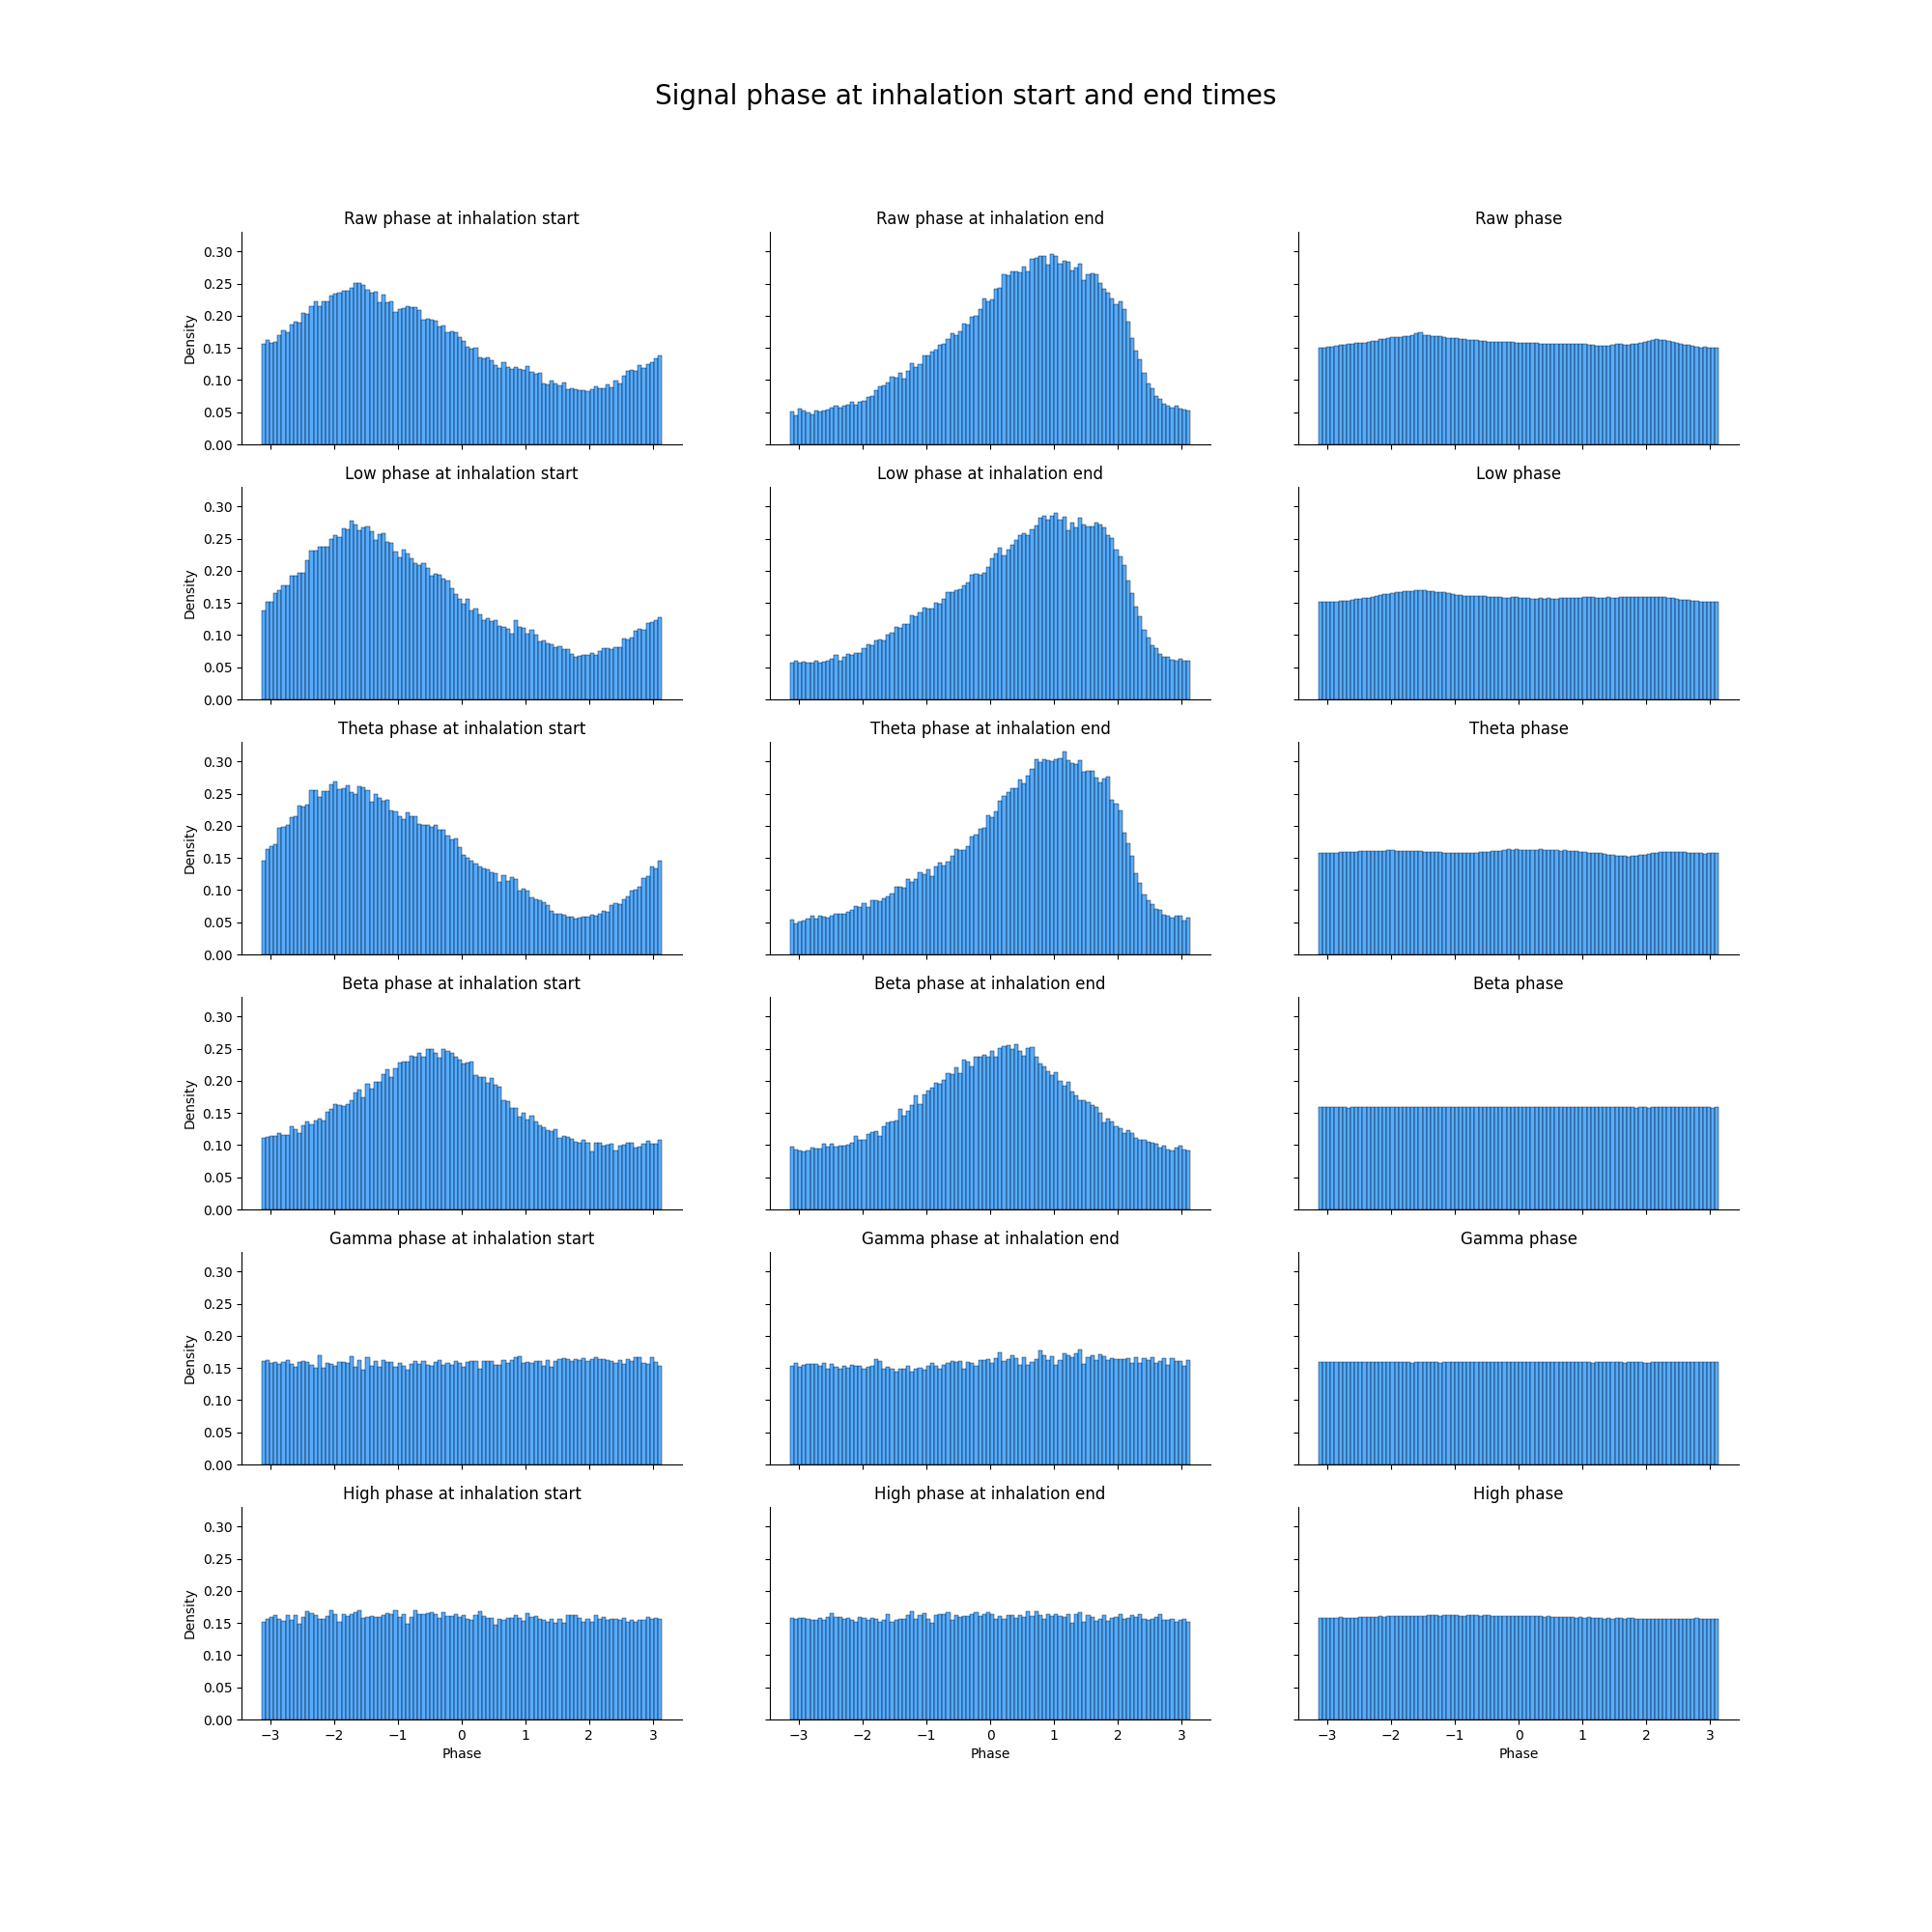

In [6]:

fig, axs = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

# plotting the phase histograms at inhale start times
sns.histplot(df[df['inhale_start'] == 1]['raw_lfp_phase'], bins=100, ax=axs[0,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['raw_lfp_phase'], bins=100, ax=axs[0,1], stat='density', color = 'dodgerblue')
sns.histplot(df['raw_lfp_phase'], bins=100, ax=axs[0,2], stat='density', color = 'dodgerblue')
axs[0,0].set_title('Raw phase at inhalation start')
axs[0,1].set_title('Raw phase at inhalation end')
axs[0,2].set_title('Raw phase')

sns.histplot(df[df['inhale_start'] == 1]['low_phase'], bins=100, ax=axs[1,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['low_phase'], bins=100, ax=axs[1,1], stat='density', color = 'dodgerblue')
sns.histplot(df['low_phase'], bins=100, ax=axs[1,2], stat='density', color = 'dodgerblue')
axs[1,0].set_title('Low phase at inhalation start')
axs[1,1].set_title('Low phase at inhalation end')
axs[1,2].set_title('Low phase')

sns.histplot(df[df['inhale_start'] == 1]['theta_phase'], bins=100, ax=axs[2,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['theta_phase'], bins=100, ax=axs[2,1], stat='density', color = 'dodgerblue')
sns.histplot(df['theta_phase'], bins=100, ax=axs[2,2], stat='density', color = 'dodgerblue')
axs[2,0].set_title('Theta phase at inhalation start')
axs[2,1].set_title('Theta phase at inhalation end')
axs[2,2].set_title('Theta phase')

sns.histplot(df[df['inhale_start'] == 1]['beta_phase'], bins=100, ax=axs[3,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['beta_phase'], bins=100, ax=axs[3,1], stat='density', color = 'dodgerblue')
sns.histplot(df['beta_phase'], bins=100, ax=axs[3,2], stat='density', color = 'dodgerblue')
axs[3,0].set_title('Beta phase at inhalation start')
axs[3,1].set_title('Beta phase at inhalation end')
axs[3,2].set_title('Beta phase')

sns.histplot(df[df['inhale_start'] == 1]['gamma_phase'], bins=100, ax=axs[4,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['gamma_phase'], bins=100, ax=axs[4,1], stat='density', color = 'dodgerblue')
sns.histplot(df['gamma_phase'], bins=100, ax=axs[4,2], stat='density', color = 'dodgerblue')
axs[4,0].set_title('Gamma phase at inhalation start')
axs[4,1].set_title('Gamma phase at inhalation end')
axs[4,2].set_title('Gamma phase')

sns.histplot(df[df['inhale_start'] == 1]['high_phase'], bins=100, ax=axs[5,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['high_phase'], bins=100, ax=axs[5,1], stat='density', color = 'dodgerblue')
sns.histplot(df['high_phase'], bins=100, ax=axs[5,2], stat='density', color = 'dodgerblue')
axs[5,0].set_title('High phase at inhalation start')
axs[5,1].set_title('High phase at inhalation end')
axs[5,2].set_title('High phase')

# labeling the x axis
axs[5,0].set_xlabel('Phase')
axs[5,1].set_xlabel('Phase')
axs[5,2].set_xlabel('Phase')

# despining the plots
for i in range(6):
    for j in range(3):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)



# setting the title
fig.text(0.5, 0.95, 'Signal phase at inhalation start and end times', ha='center', va='center', fontsize=20)


plt.show()


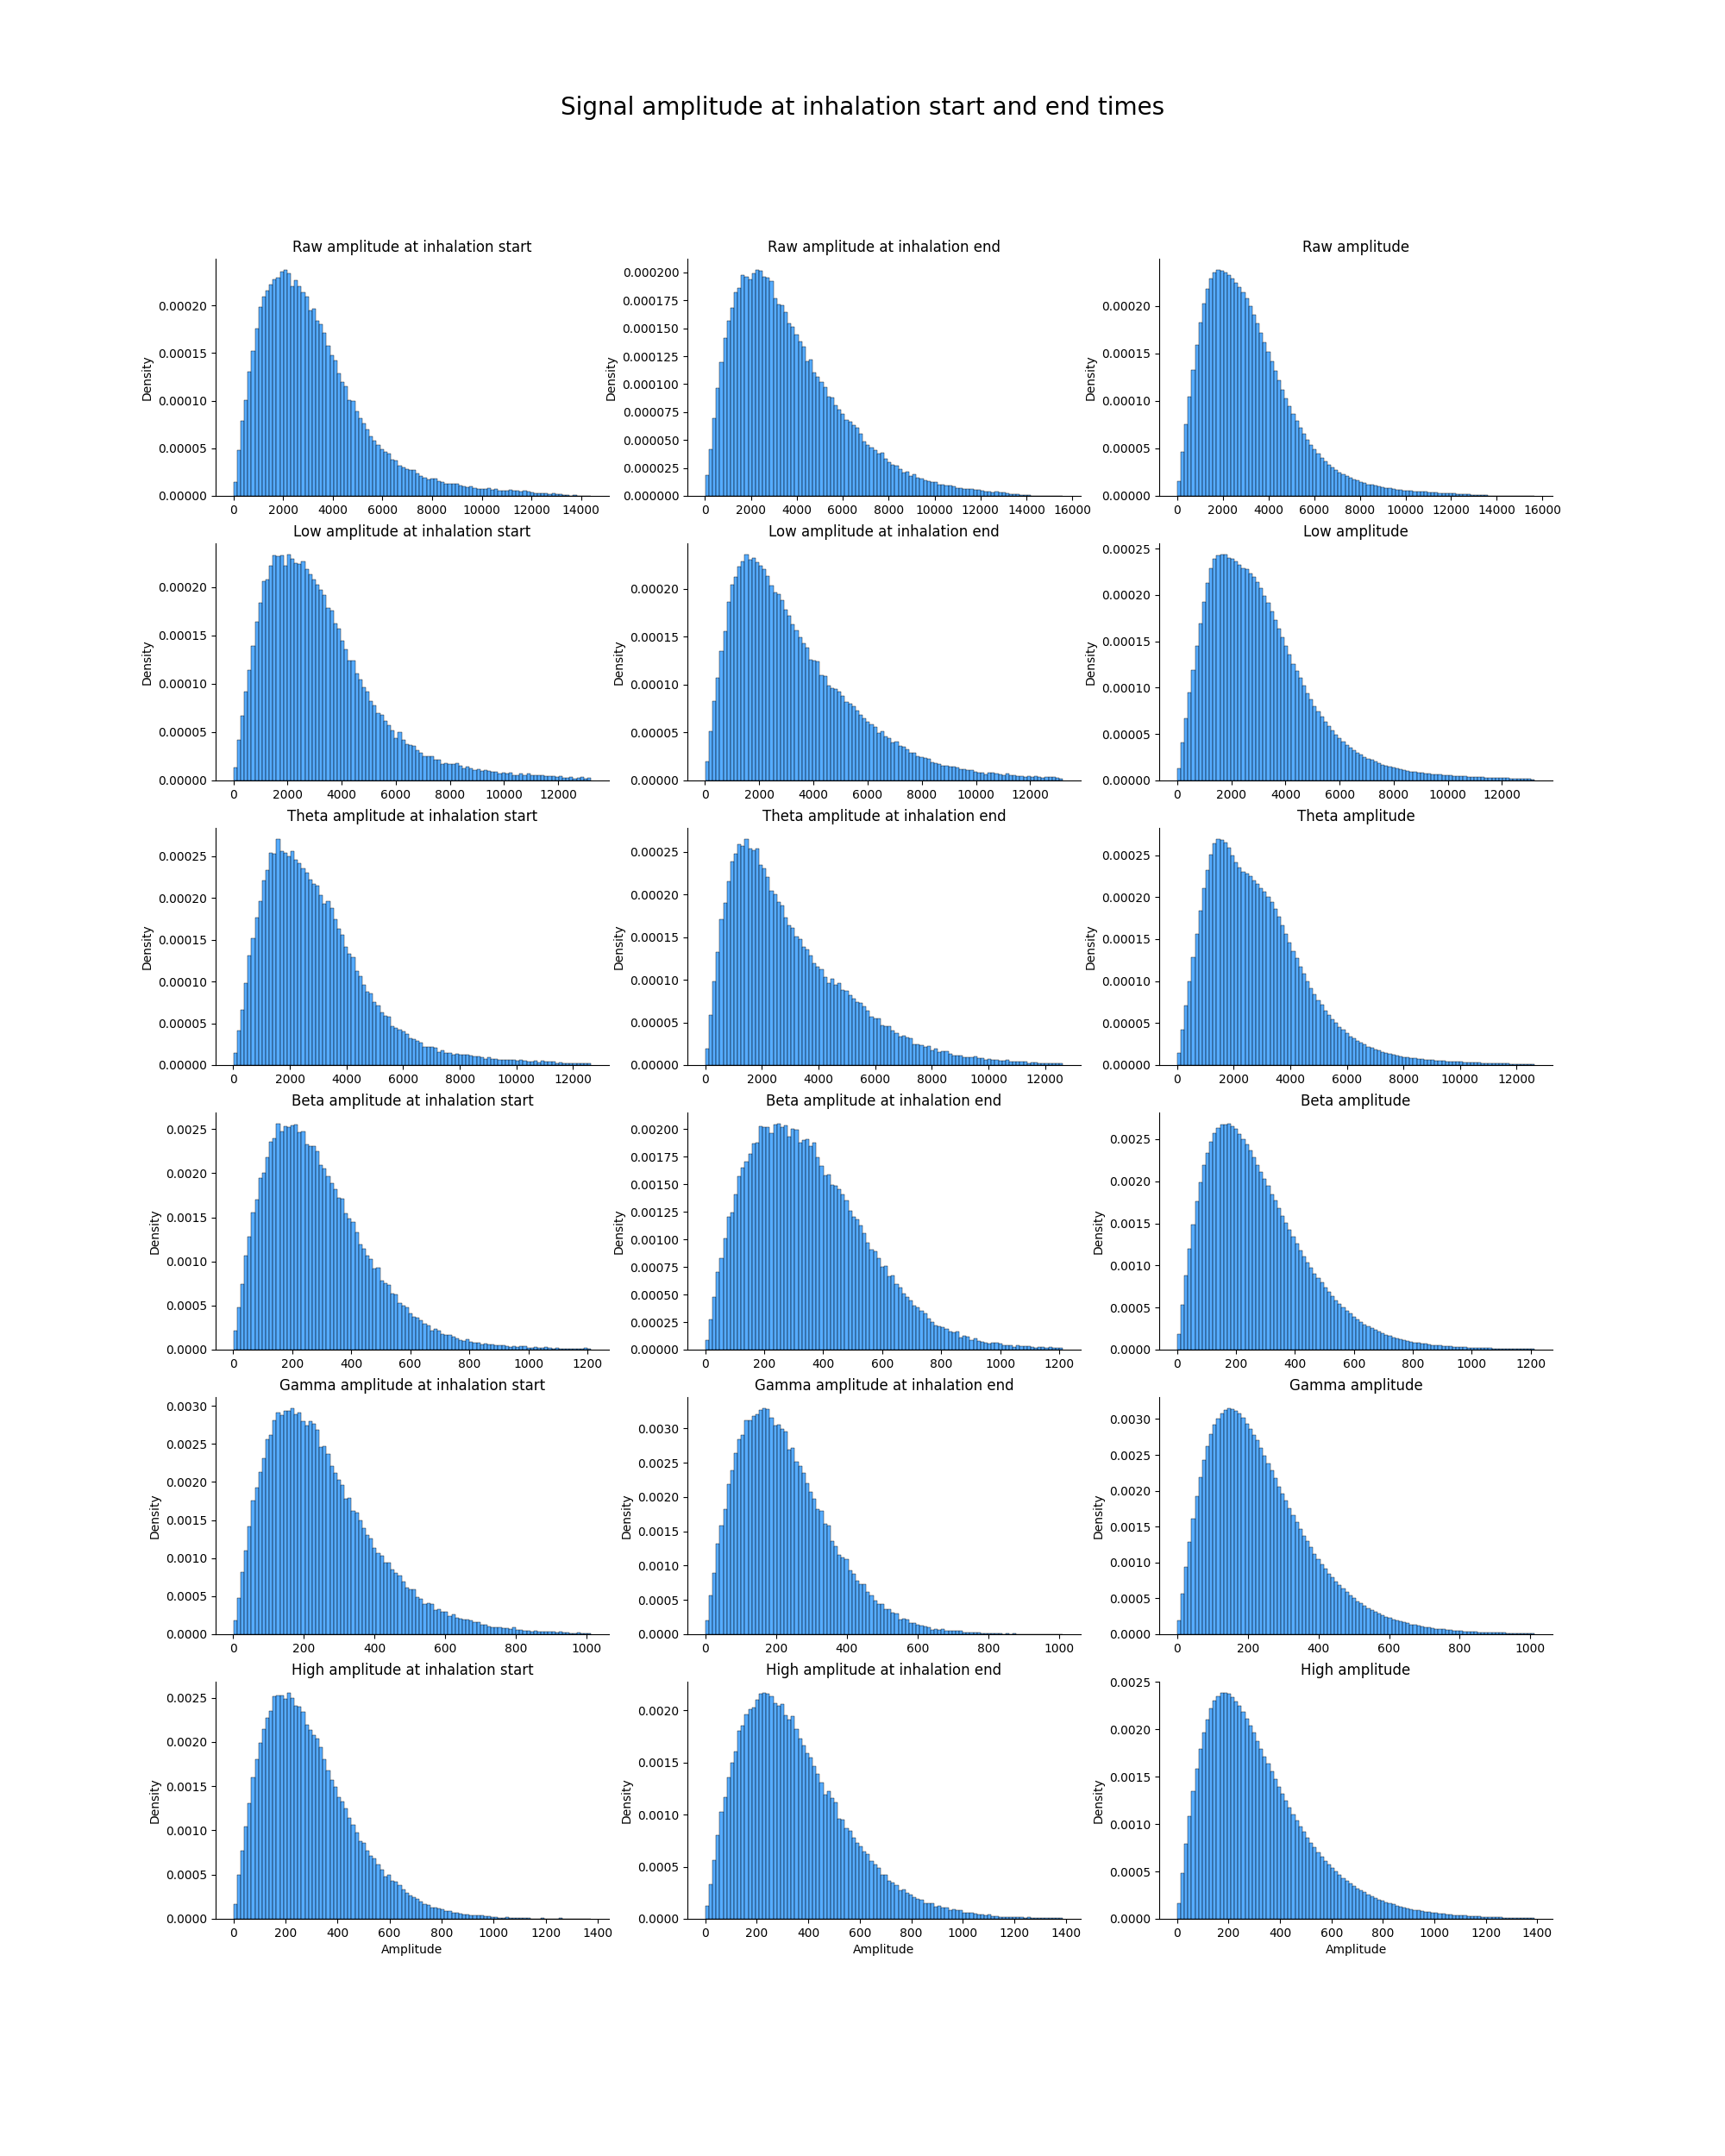

In [7]:



fig, axs = plt.subplots(6,3, figsize=(20,25))

# plotting the raw, low, theta, beta, gamma, high amplitude histograms at inhale start and end times
sns.histplot(df[df['inhale_start'] == 1]['raw_lfp_amplitude'], bins=100, ax=axs[0,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['raw_lfp_amplitude'], bins=100, ax=axs[0,1], stat='density', color = 'dodgerblue')
sns.histplot(df['raw_lfp_amplitude'], bins=100, ax=axs[0,2], stat='density', color = 'dodgerblue')
axs[0,0].set_title('Raw amplitude at inhalation start')
axs[0,1].set_title('Raw amplitude at inhalation end')
axs[0,2].set_title('Raw amplitude')

sns.histplot(df[df['inhale_start'] == 1]['low_amplitude'], bins=100, ax=axs[1,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['low_amplitude'], bins=100, ax=axs[1,1], stat='density', color = 'dodgerblue')
sns.histplot(df['low_amplitude'], bins=100, ax=axs[1,2], stat='density', color = 'dodgerblue')
axs[1,0].set_title('Low amplitude at inhalation start')
axs[1,1].set_title('Low amplitude at inhalation end')
axs[1,2].set_title('Low amplitude')

sns.histplot(df[df['inhale_start'] == 1]['theta_amplitude'], bins=100, ax=axs[2,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['theta_amplitude'], bins=100, ax=axs[2,1], stat='density', color = 'dodgerblue')
sns.histplot(df['theta_amplitude'], bins=100, ax=axs[2,2], stat='density', color = 'dodgerblue')
axs[2,0].set_title('Theta amplitude at inhalation start')
axs[2,1].set_title('Theta amplitude at inhalation end')
axs[2,2].set_title('Theta amplitude')

sns.histplot(df[df['inhale_start'] == 1]['beta_amplitude'], bins=100, ax=axs[3,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['beta_amplitude'], bins=100, ax=axs[3,1], stat='density', color = 'dodgerblue')
sns.histplot(df['beta_amplitude'], bins=100, ax=axs[3,2], stat='density', color = 'dodgerblue')
axs[3,0].set_title('Beta amplitude at inhalation start')
axs[3,1].set_title('Beta amplitude at inhalation end')
axs[3,2].set_title('Beta amplitude')

sns.histplot(df[df['inhale_start'] == 1]['gamma_amplitude'], bins=100, ax=axs[4,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['gamma_amplitude'], bins=100, ax=axs[4,1], stat='density', color = 'dodgerblue')
sns.histplot(df['gamma_amplitude'], bins=100, ax=axs[4,2], stat='density', color = 'dodgerblue')
axs[4,0].set_title('Gamma amplitude at inhalation start')
axs[4,1].set_title('Gamma amplitude at inhalation end')
axs[4,2].set_title('Gamma amplitude')

sns.histplot(df[df['inhale_start'] == 1]['high_amplitude'], bins=100, ax=axs[5,0], stat='density', color = 'dodgerblue')
sns.histplot(df[df['inhale_end'] == 1]['high_amplitude'], bins=100, ax=axs[5,1], stat='density', color = 'dodgerblue')
sns.histplot(df['high_amplitude'], bins=100, ax=axs[5,2], stat='density', color = 'dodgerblue')
axs[5,0].set_title('High amplitude at inhalation start')
axs[5,1].set_title('High amplitude at inhalation end')
axs[5,2].set_title('High amplitude')

# labeling the x axis
axs[5,0].set_xlabel('Amplitude')
axs[5,1].set_xlabel('Amplitude')
axs[5,2].set_xlabel('Amplitude')

for i in range(5):
    for j in range(3):
        axs[i,j].set_xlabel('')

# despining the plots
for i in range(6):
    for j in range(3):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)


# setting the title
fig.text(0.5, 0.95, 'Signal amplitude at inhalation start and end times', ha='center', va='center', fontsize=20)

plt.show()



In [12]:
session = 3
plot_df = df[df['session'] == session]

# keeping only the middle section of the data
plot_df = plot_df.iloc[int(len(plot_df)*4/10):int(len(plot_df)*4.01/10)]

# scaling sniff signal
plot_df['sniff'] = plot_df['sniff'] * 2000

# scaling phase for plotting
plot_df['raw_lfp_phase'] = plot_df['raw_lfp_phase'] * 500
plot_df['theta_phase'] = plot_df['theta_phase'] * 500
plot_df['beta_phase'] = plot_df['beta_phase'] * 500
plot_df['high_phase'] = plot_df['high_phase'] * 500
plot_df['low_phase'] = plot_df['low_phase'] * 500
plot_df['gamma_phase'] = plot_df['gamma_phase'] * 500








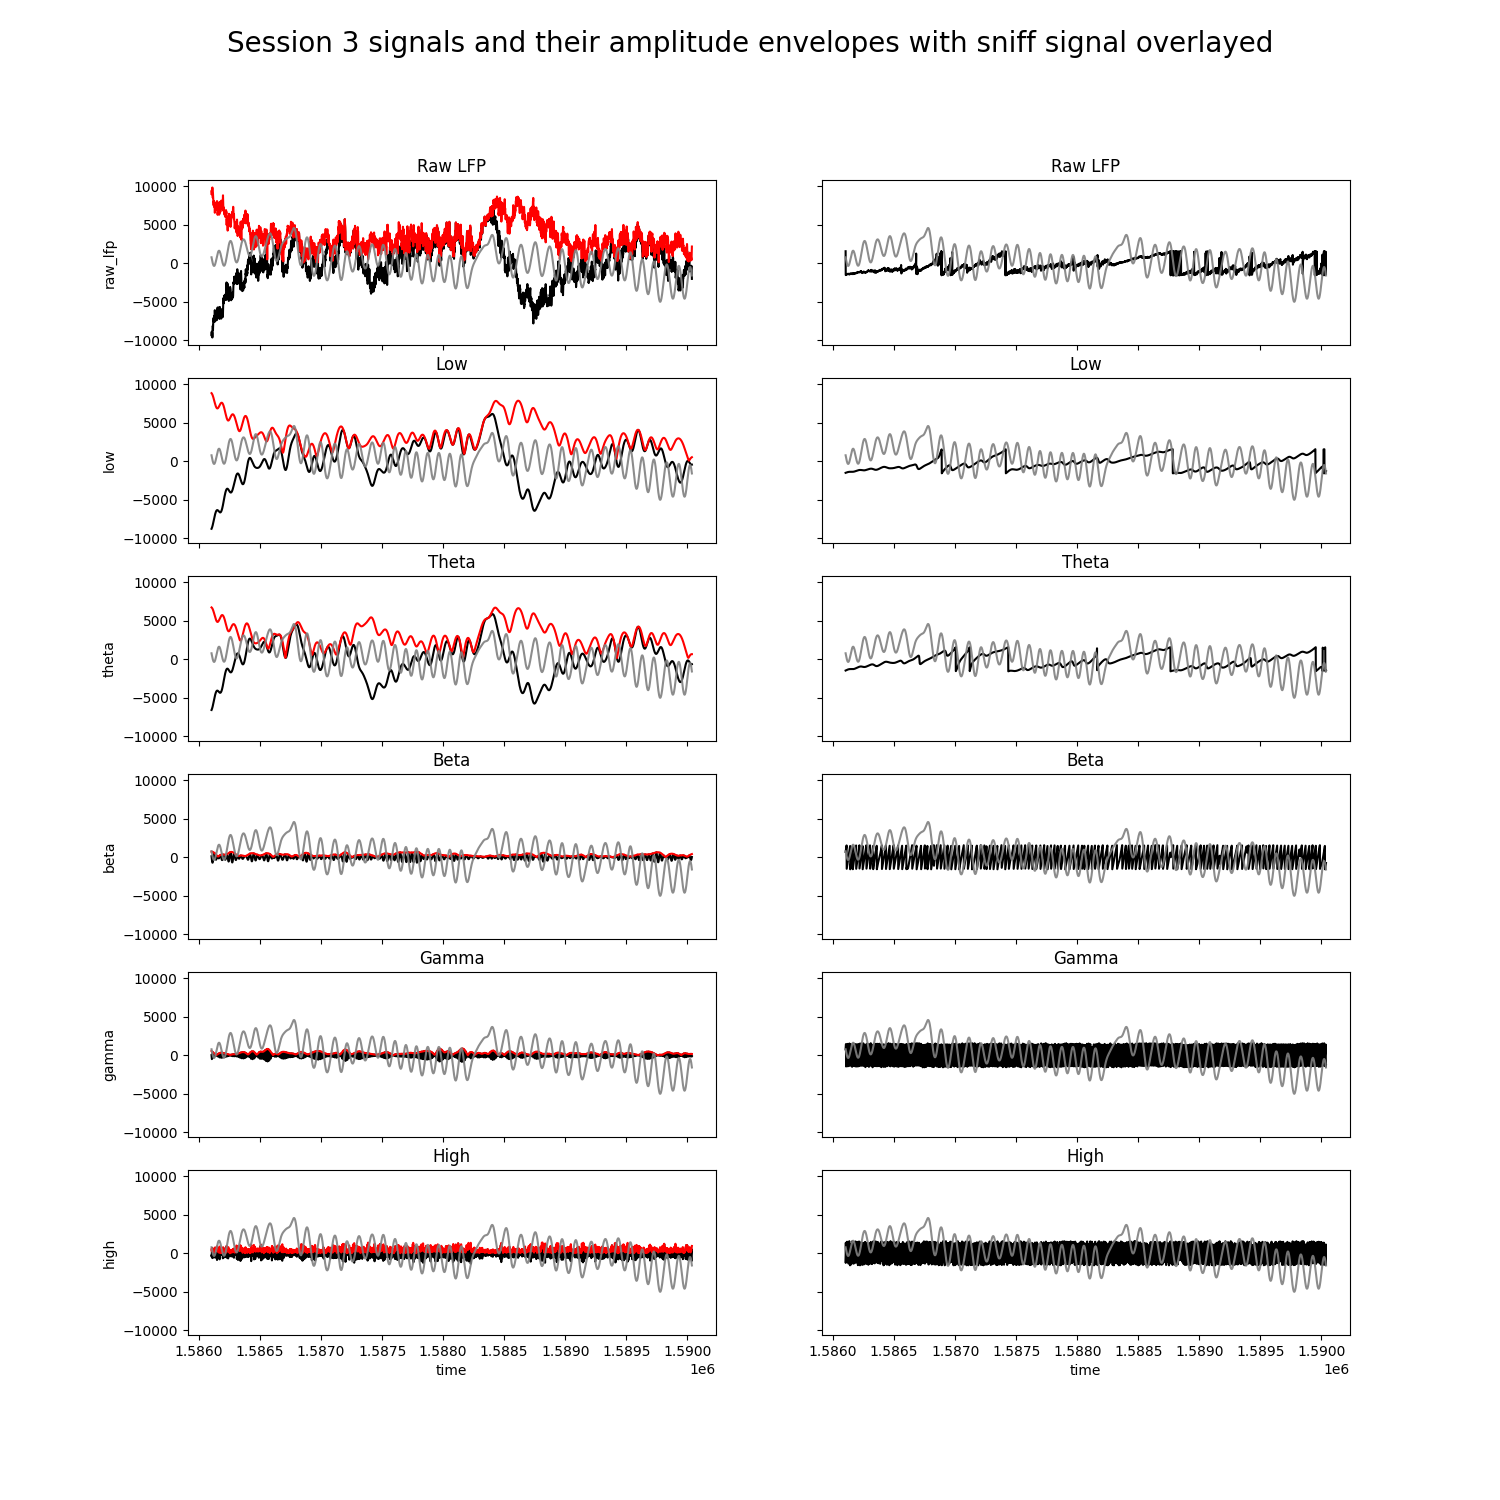

In [13]:
fig, axes = plt.subplots(6, 2, figsize=(15, 15), sharex=True, sharey=True)

# plotting the signals and their amplitude envelopes with the sniff signal overlayed
sns.lineplot(x='time', y='raw_lfp', data=plot_df, ax=axes[0, 0], color='black')
sns.lineplot(x='time', y='raw_lfp_amplitude', data=plot_df, ax=axes[0, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[0, 0], color='gray', alpha = 0.9)
axes[0,0].set_title('Raw LFP')

sns.lineplot(x='time', y='low', data=plot_df, ax=axes[1, 0], color='black')
sns.lineplot(x='time', y='low_amplitude', data=plot_df, ax=axes[1, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[1, 0], color='gray', alpha = 0.9)
axes[1,0].set_title('Low')

sns.lineplot(x='time', y='theta', data=plot_df, ax=axes[2, 0], color='black')
sns.lineplot(x='time', y='theta_amplitude', data=plot_df, ax=axes[2, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[2, 0], color='gray', alpha = 0.9)
axes[2,0].set_title('Theta')

sns.lineplot(x='time', y='beta', data=plot_df, ax=axes[3, 0], color='black')
sns.lineplot(x='time', y='beta_amplitude', data=plot_df, ax=axes[3, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[3, 0], color='gray', alpha = 0.9)
axes[3,0].set_title('Beta')

sns.lineplot(x='time', y='gamma', data=plot_df, ax=axes[4, 0], color='black')
sns.lineplot(x='time', y='gamma_amplitude', data=plot_df, ax=axes[4, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[4, 0], color='gray', alpha = 0.9)
axes[4,0].set_title('Gamma')

sns.lineplot(x='time', y='high', data=plot_df, ax=axes[5, 0], color='black')
sns.lineplot(x='time', y='high_amplitude', data=plot_df, ax=axes[5, 0], color='red')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[5, 0], color='gray', alpha = 0.9)
axes[5,0].set_title('High')



# plotting the phase with the sniff signal overlayed
sns.lineplot(x='time', y='raw_lfp_phase', data=plot_df, ax=axes[0, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[0, 1], color='gray', alpha = 0.9)
axes[0,1].set_title('Raw LFP')

sns.lineplot(x='time', y='low_phase', data=plot_df, ax=axes[1, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[1, 1], color='gray', alpha = 0.9)
axes[1,1].set_title('Low')

sns.lineplot(x='time', y='theta_phase', data=plot_df, ax=axes[2, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[2, 1], color='gray', alpha = 0.9)
axes[2,1].set_title('Theta')

sns.lineplot(x='time', y='beta_phase', data=plot_df, ax=axes[3, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[3, 1], color='gray', alpha = 0.9)
axes[3,1].set_title('Beta')

sns.lineplot(x='time', y='gamma_phase', data=plot_df, ax=axes[4, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[4, 1], color='gray', alpha = 0.9)
axes[4,1].set_title('Gamma')

sns.lineplot(x='time', y='high_phase', data=plot_df, ax=axes[5, 1], color='black')
sns.lineplot(x='time', y='sniff', data=plot_df, ax=axes[5, 1], color='gray', alpha = 0.9)
axes[5,1].set_title('High')

# setting title
fig.suptitle(f'Session {session} signals and their amplitude envelopes with sniff signal overlayed', fontsize=20)





plt.show()



In [15]:

# Function to detect phase resets
def detect_phase_resets(phase_array):
    phase_diff = np.diff(phase_array)
    phase_diff = np.where(phase_diff < -np.pi, 1, 0)
    phase_diff = np.insert(phase_diff, 0, 0)  # Insert 0 at the beginning
    return phase_diff

# List of phase columns
phase_columns = ['raw_lfp_phase', 'low_phase', 'theta_phase', 'beta_phase', 'gamma_phase', 'high_phase']

# Process each phase column and create corresponding reset columns
for col in tqdm(phase_columns, desc='Columns'):
    phase_values = df[col].values
    reset_col_name = f'{col}_reset'
    df[reset_col_name] = detect_phase_resets(phase_values)



 #convert 'time' column to numpy array for faster access
time_array = df['time'].values

# Finding the latency between inhalation start time and phase reset using 'time' column
latency_list = []

for col in phase_columns:
    reset_col_name = f'{col}_reset'
    inhale_starts = df[df['inhale_start'] == 1].index
    reset_indices = df.index[df[reset_col_name] == 1].values

    for idx in tqdm(inhale_starts, desc='Inhalation starts'):
        # Find the first reset after the inhalation start
        subsequent_resets = reset_indices[reset_indices >= idx]
        if len(subsequent_resets) > 0:
            reset_idx = subsequent_resets[0]
            start_time = time_array[idx]
            reset_time = time_array[reset_idx]
            latency = reset_time - start_time
            latency_list.append({'session': df.loc[idx, 'session'], 'phase': col, 'latency': latency})


latency_df = pd.DataFrame(latency_list)
print(latency_df.head())


Inhalation starts:  35%|███▍      | 38251/110821 [00:09<00:16, 4354.33it/s]

In [12]:
print(latency_df.shape)
print(latency_df.columns)
print(latency_df['phase'].unique())

# removing outliers
latency_df_clean = pd.DataFrame()
for phase in latency_df['phase'].unique():
    phase_data = latency_df[latency_df['phase'] == phase]
    zscores = np.abs(stats.zscore(phase_data['latency']))
    phase_data_clean = phase_data[zscores < 3]
    latency_df_clean = pd.concat([latency_df_clean, phase_data_clean], ignore_index=True)

(667044, 3)
Index(['session', 'phase', 'latency'], dtype='object')
['raw_lfp_phase' 'low_phase' 'theta_phase' 'beta_phase' 'gamma_phase'
 'high_phase']


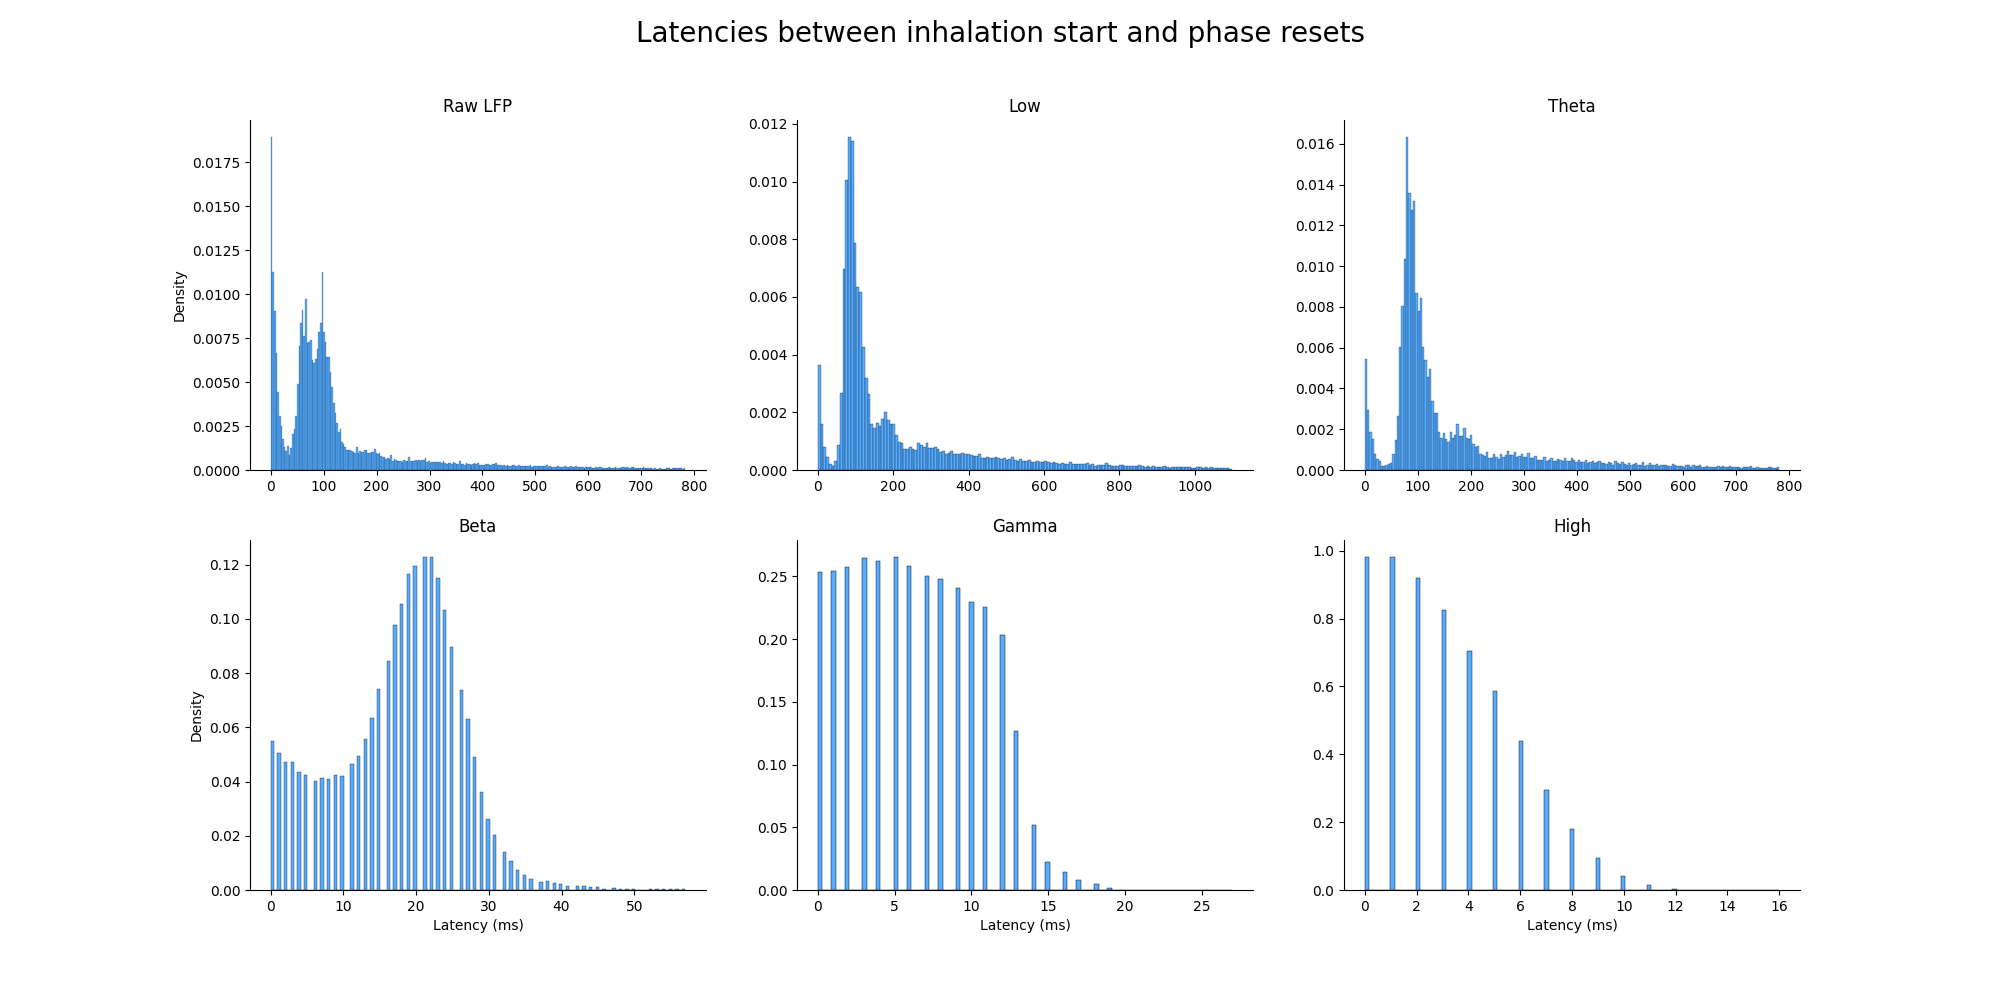

In [13]:
# plotting histograms of latencies
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'raw_lfp_phase']['latency'], ax=axs[0, 0], stat='density', color='dodgerblue')
axs[0, 0].set_title('Raw LFP')

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'low_phase']['latency'], ax=axs[0, 1], stat='density', color='dodgerblue')
axs[0, 1].set_title('Low')

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'theta_phase']['latency'], ax=axs[0, 2], stat='density', color='dodgerblue')
axs[0, 2].set_title('Theta')

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'beta_phase']['latency'], ax=axs[1, 0], stat='density', color='dodgerblue')
axs[1, 0].set_title('Beta')

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'gamma_phase']['latency'],  ax=axs[1, 1], stat='density', color='dodgerblue')
axs[1, 1].set_title('Gamma')

sns.histplot(latency_df_clean[latency_df_clean['phase'] == 'high_phase']['latency'], ax=axs[1, 2], stat='density', color='dodgerblue')
axs[1, 2].set_title('High')

# setting the title
fig.suptitle('Latencies between inhalation start and phase resets', fontsize=20)

for i in range(2):
    for j in range(3):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)
        if j != 0:
            axs[i,j].set_ylabel('')
        if i == 1:
            axs[i,j].set_xlabel('Latency (ms)')
        else:
            axs[i,j].set_xlabel('')

plt.show()

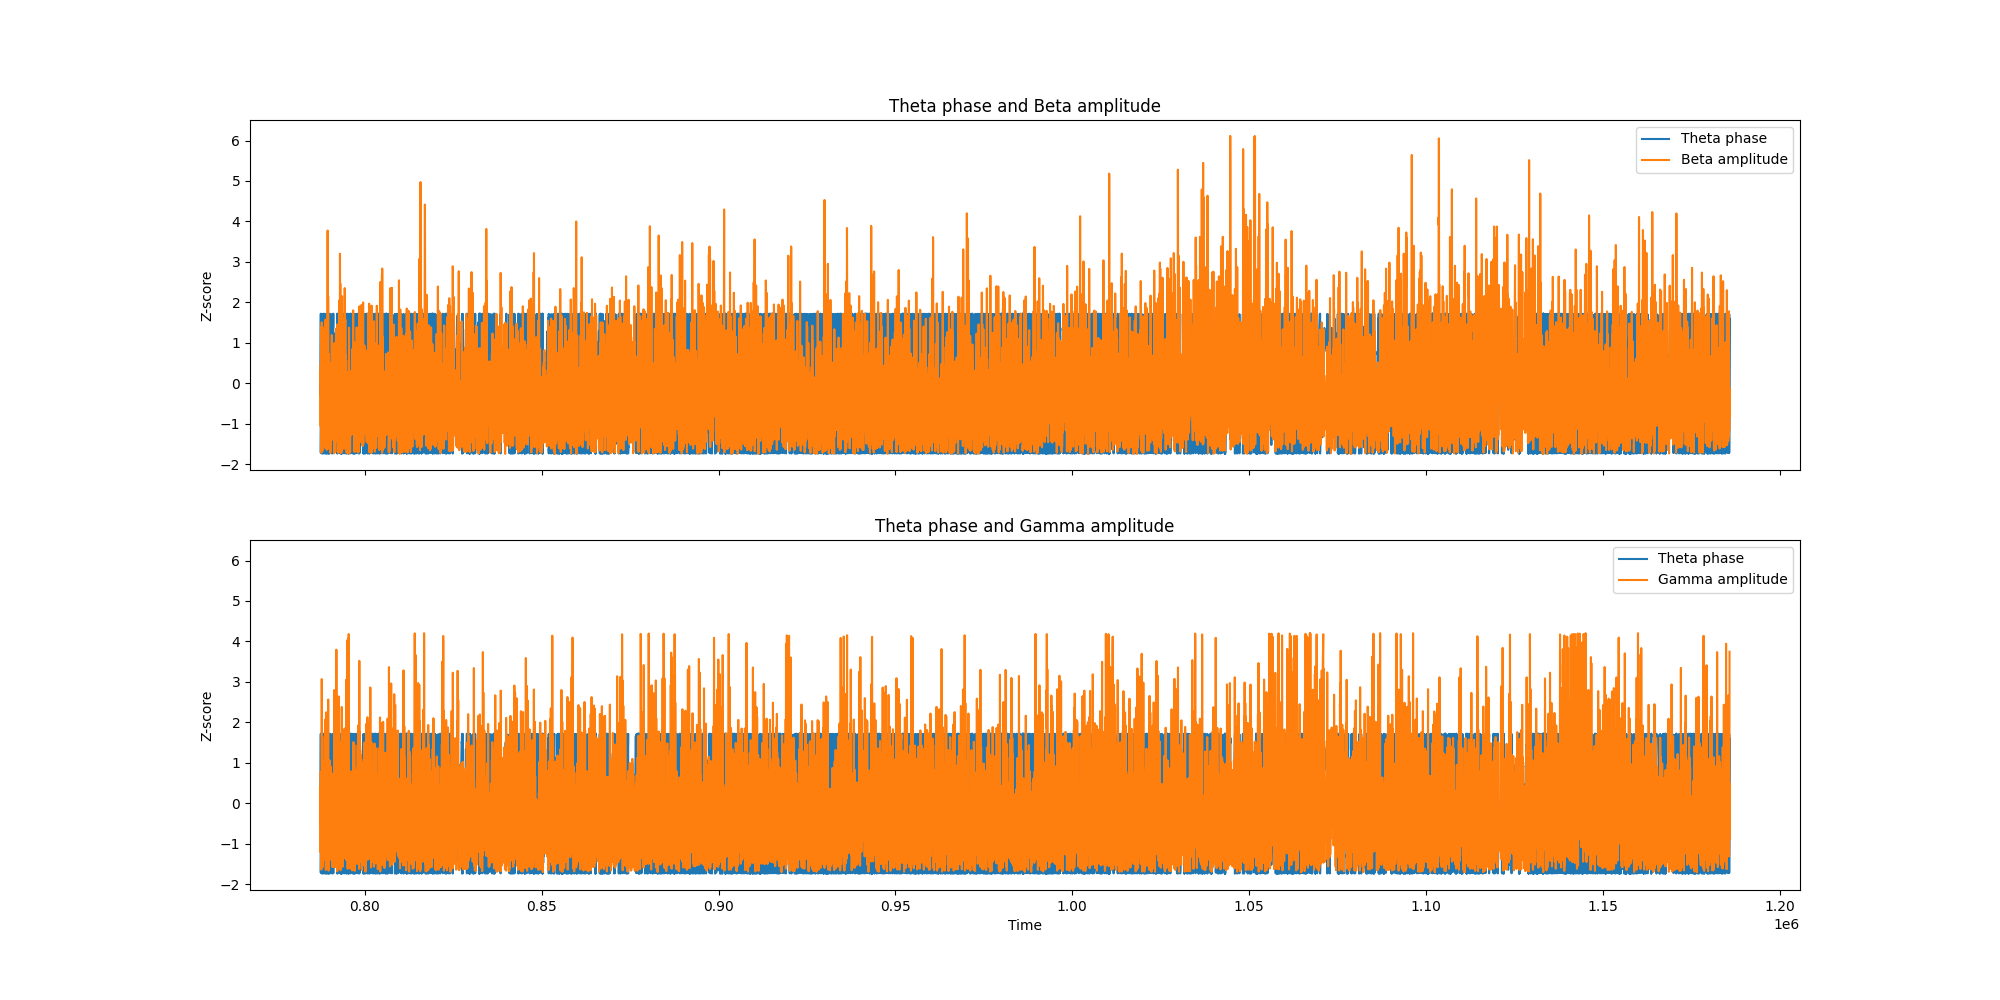

In [14]:
plt.close('all')


plot_df['theta_phase_zscore'] = stats.zscore(plot_df['theta_phase'])
plot_df['beta_amplitude_zscore'] = stats.zscore(plot_df['beta_amplitude'])
plot_df['gamma_amplitude_zscore'] = stats.zscore(plot_df['gamma_amplitude'])



# plotting theta phase and beta amplitude
fig, axs = plt.subplots(2,1, figsize=(20, 10), sharex=True, sharey=True)

sns.lineplot(x='time', y='theta_phase_zscore', data=plot_df, ax = axs[0], label='Theta phase')
sns.lineplot(x='time', y='beta_amplitude_zscore', data=plot_df, ax = axs[0], label='Beta amplitude')
axs[0].set_title('Theta phase and Beta amplitude')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Z-score')
axs[0].legend()

sns.lineplot(x='time', y='theta_phase_zscore', data=plot_df, ax = axs[1], label='Theta phase')
sns.lineplot(x='time', y='gamma_amplitude_zscore', data=plot_df, ax = axs[1], label='Gamma amplitude')
axs[1].set_title('Theta phase and Gamma amplitude')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Z-score')
axs[1].legend()



plt.show()





### Computing the Kullback-Leibler Modulation Index (KLMI)

For the phase-amplitude coupling analysis, we compute the Kullback-Leibler Modulation Index (KLMI) which is a measure of the modulation of the amplitude distribution by the phase distribution. The KLMI is given by:

$$
\text{KLMI} = \frac{1}{\log(n)} \sum_{k = 1}^{n} p_k \log\left(\frac{p_k}{u_k}\right)
$$

where $p_k$ and $u_k$ are the probability distributions of the amplitude and phase respectively. The KLMI ranges from 0 to 1 where 0 indicates no coupling and 1 indicates perfect coupling.

In [15]:
# computing modulation index between theta phase and beta amplitude
def compute_modulation_index(phase_data, amplitude_data, nbins=18):
    bins = np.linspace(-np.pi, np.pi, nbins + 1)
    bin_means = np.zeros(nbins)

    for i in range(nbins):
        bin_indices = (phase_data >= bins[i]) & (phase_data < bins[i + 1])
        if np.any(bin_indices):  # Ensure there's data in the bin
            bin_means[i] = np.mean(amplitude_data[bin_indices])

    # normalizing bin_means
    bin_means /= np.sum(bin_means)

    # getting the uniform distribution
    uniform_distribution = np.ones(nbins) / nbins

    # adding and epsilon
    eps = 1e-10
    bin_means += eps
    uniform_distribution += eps
    
    # compute modulation index
    MI = 1 / np.log(nbins) * np.sum(bin_means * np.log(bin_means / uniform_distribution))

    return MI


# computing modulation index for theta phase and beta amplitude
theta_phase = df['theta_phase'].values
beta_amplitude = df['beta_amplitude'].values
MI = compute_modulation_index(theta_phase, beta_amplitude)
print(f'Modulation index between theta phase and beta amplitude is {MI}')







Modulation index between theta phase and beta amplitude is 0.0005236823381595989


In [16]:
# computing the modulation index for allcombinations
nbins = 36
MI_list = []
phase_columns = ['raw_lfp_phase', 'low_phase', 'theta_phase', 'beta_phase', 'gamma_phase', 'high_phase']
amplitude_columns = ['raw_lfp_amplitude', 'low_amplitude', 'theta_amplitude', 'beta_amplitude', 'gamma_amplitude', 'high_amplitude']

for phase_col in tqdm(phase_columns, desc='Phase columns'):
    phase_data = df[phase_col].values
    for amplitude_col in amplitude_columns:
        amplitude_data = df[amplitude_col].values
        MI = compute_modulation_index(phase_data, amplitude_data, nbins = nbins)
        MI_list.append({'phase': phase_col, 'amplitude': amplitude_col, 'MI': MI})

MI_df = pd.DataFrame(MI_list)
MI_matrix = MI_df.pivot(index='phase', columns='amplitude', values='MI')



Phase columns: 100%|██████████| 6/6 [02:54<00:00, 29.09s/it]


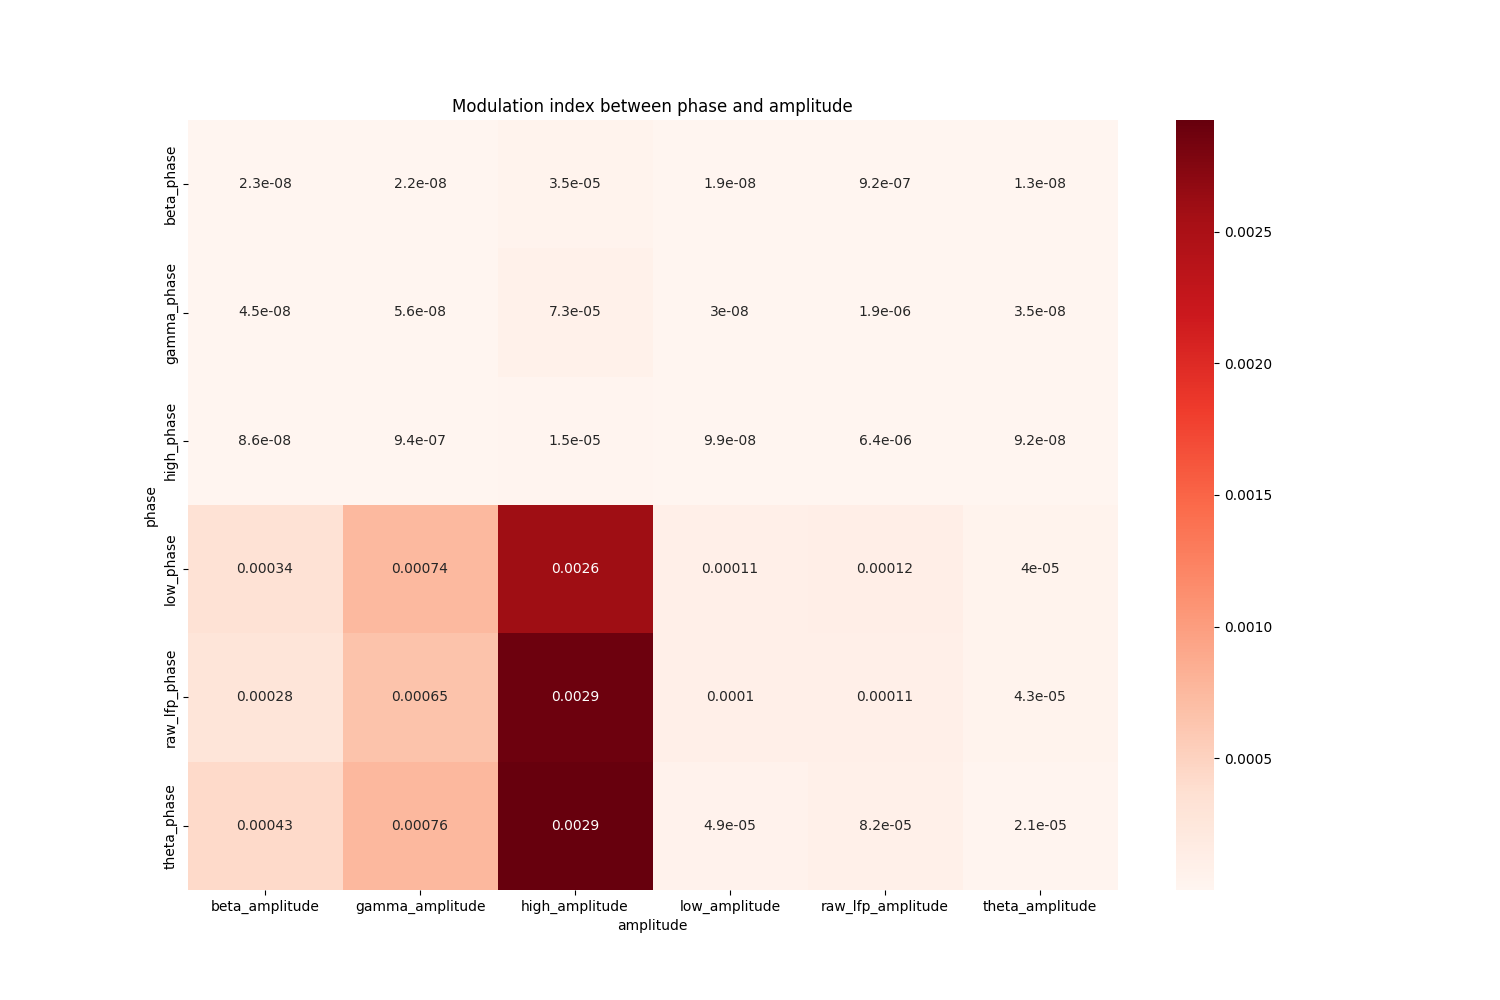

In [17]:
# plotting the modulation index as a heatmap

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(MI_matrix, annot=True, ax=ax, cmap='Reds')
ax.set_title('Modulation index between phase and amplitude')
plt.show()





### Computing the Mutual Information (MI)

The Mutual Information (MI) is a measure of the mutual dependence between two random variables. The MI is given by:

$$
\text{MI} = \sum_{k = 1}^{n} \sum_{j = 1}^{m} p_{kj} \log\left(\frac{p_{kj}}{p_k p_j}\right)
$$

where $p_{kj}$ is the joint probability distribution of the amplitude and phase, and $p_k$ and $p_j$ are the marginal probability distributions of the amplitude and phase respectively. The MI ranges from 0 to $\infty$ where 0 indicates no mutual dependence and $\infty$ indicates perfect mutual dependence.



In [18]:
# computing the mutual information
def compute_mi_kde(x, y, eps=1e-10):
    # Perform Kernel Density Estimation
    kde_x = stats.gaussian_kde(x)
    kde_y = stats.gaussian_kde(y)
    kde_xy = stats.gaussian_kde(np.vstack([x, y]))
    
    # Define a grid for integration
    xi, yi = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    positions = np.vstack([xi.ravel(), yi.ravel()])
    
    # Evaluate the KDEs on the grid
    px = kde_x(xi.ravel()).reshape(xi.shape)
    py = kde_y(yi.ravel()).reshape(yi.shape)
    pxy = kde_xy(positions).reshape(xi.shape)

    # Add a small value to prevent log(0)
    px = np.clip(px, eps, None)
    py = np.clip(py, eps, None)
    pxy = np.clip(pxy, eps, None)
    
    # Compute mutual information
    mi = np.sum(pxy * np.log(pxy / (px * py)))
    return mi

def compute_mi_bins(x, y, nbins):
    x_binned = np.digitize(x, bins = np.linspace(min(x), max(x), nbins))
    y_binned = np.digitize(y, bins = np.linspace(min(y), max(y), nbins))
    return mutual_info_score(x_binned, y_binned)

# computing the mutual information for all combinations
MI_list = []
for phase_col in tqdm(phase_columns, desc='Phase columns'):
    phase_data = df[phase_col].values
    for amplitude_col in amplitude_columns:
        amplitude_data = df[amplitude_col].values
        MI = compute_mi_bins(phase_data, amplitude_data, nbins = nbins)
        MI_list.append({'phase': phase_col, 'amplitude': amplitude_col, 'MI': MI})

MI_df = pd.DataFrame(MI_list)
MI_matrix = MI_df.pivot(index='phase', columns='amplitude', values='MI')







Phase columns:   0%|          | 0/6 [00:57<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# plotting the mutual information as a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(MI_matrix, annot=True, ax=ax, cmap='Reds')
ax.set_title('Mutual information between phase and amplitude')
plt.show()


### Exploring MI and KLMI at different shifts of the phase and signal

We explore the MI and KLMI at different shifts of the phase and signal to see if there is a phase lag in the coupling.




In [ ]:
# computing the MI and KLMI for theta phase and gamma amplitude at multiple circular shifts

nshifts = 30
MI_list = []
KLMI_list = []

theta_phase = df['theta_phase'].values
gamma_amplitude = df['gamma_amplitude'].values

for shift in tqdm(range(nshifts), desc='Shifts'):
    theta_phase_shifted = np.roll(theta_phase, -shift)
    MI = compute_mi_bins(theta_phase_shifted, gamma_amplitude, nbins = nbins)
    MI_list.append({'shift': shift, 'MI': MI})
    KLMI = compute_modulation_index(theta_phase_shifted, gamma_amplitude, nbins = nbins)
    KLMI_list.append({'shift': shift, 'KLMI': KLMI})

MI_df = pd.DataFrame(MI_list)
KLMI_df = pd.DataFrame(KLMI_list)




In [ ]:
# plotting the MI and KLMI for theta phase and gamma amplitude at multiple circular shifts
fig, axs = plt.subplots(2,1, figsize=(15, 10), sharex=True)

sns.lineplot(x='shift', y='MI', data=MI_df, ax=axs[0])
axs[0].set_title('Mutual information between theta phase and gamma amplitude at multiple shifts')
axs[0].set_xlabel('Shift')
axs[0].set_ylabel('MI')

sns.lineplot(x='shift', y='KLMI', data=KLMI_df, ax=axs[1])
axs[1].set_title('KLMI between theta phase and gamma amplitude at multiple shifts')
axs[1].set_xlabel('Shift')
axs[1].set_ylabel('KLMI')

plt.show()


In [ ]:
# now shifting the phase 
nshifts = 36
MI_list = []
KLMI_list = []

theta_phase = df['theta_phase'].values
gamma_amplitude = df['gamma_amplitude'].values

for shift in tqdm(range(nshifts), desc='Shifts'):
    amount = 2 * np.pi * shift / nshifts
    theta_phase_shifted = np.mod(theta_phase + amount, 2 * np.pi)
    MI = compute_mi_bins(theta_phase_shifted, gamma_amplitude, nbins = nbins)
    MI_list.append({'shift': shift, 'MI': MI})
    KLMI = compute_modulation_index(theta_phase_shifted, gamma_amplitude, nbins = nbins)
    KLMI_list.append({'shift': shift, 'KLMI': KLMI})
    
MI_df = pd.DataFrame(MI_list)
KLMI_df = pd.DataFrame(KLMI_list)

In [ ]:
# plotting
fig, axs = plt.subplots(2,1, figsize=(15, 10), sharex=True)

sns.lineplot(x='shift', y='MI', data=MI_df, ax=axs[0])
axs[0].set_title('Mutual information between theta phase and gamma amplitude at multiple shifts')
axs[0].set_xlabel('Shift')
axs[0].set_ylabel('MI')

sns.lineplot(x='shift', y='KLMI', data=KLMI_df, ax=axs[1])
axs[1].set_title('KLMI between theta phase and gamma amplitude at multiple shifts')
axs[1].set_xlabel('Shift')
axs[1].set_ylabel('KLMI')

plt.show()
